## Goals of this script: ## 

• Plot drive cycle (velocity over time) by route  

• Obtain total distance traveled along route, accounting for elevation change\

• Plot route on OpenStreetMap

--> Estimate the energy requirement for traveling along the route
    • the metadata will come in different csv's for each minibus, so adapt Fili's code to loop through the files and read them all in, and then for loop thru each for calculations.
---------------------------------------------------------------------------------------------------------

Current concerns:

**Distance calculation is sus** 
The issue is that you can move more than 1m with the accelerometer but it records the same lat/long (ie without more granular lat/long data, what is the best way to calculate distance)



**Slope calcluation** having issues because the change in altitude measurement appears to be more sensitive than the change in distance (i.e. two successive observations may have same lat long but different altitudes). Solution is to use arccos instead of arcsin (using lateral and 3d dist instead of altitude and 3d dist), but arcsin is preferable becauase it uses 1 measured value instead of two calculated values

**Energy Expenditure calculation** is giving way too high of a number. I think this has to do with some physical parameter. I thought maybe it had to do with sus slope calculation, but setting all slopes to 0 only decreases final sum by 500 out of tens of thousands of kWh. That is still quite a bit and could indicate that the slope calculation is wrong, but is not the main problem here. Am using V2GO output as part of the sanity check. 

In [6]:
import pandas as pd
import os
import numpy as np
import geopy.distance
import datetime
import geopandas
import matplotlib as matplotlib
import matplotlib.pyplot as plt

import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon

import folium

## Import and Clean Data

In [10]:
#df = pd.read_csv("TEST1.csv")
# current directory csv files
files = [x for x in os.listdir('.') if x.endswith('.CSV')]
fns = [os.path.splitext(os.path.basename(x))[0] for x in files]

d = {}
for i in range(len(fns)):
    d[fns[i]] = pd.read_csv(files[i])

In [15]:
d

{'KMDI - STB':           Date     Time  Latitude  Longitude  Altitude  Speed  Heading  \
 0    11/3/2022  9:29:08 -33.91867   18.85160     116.0   0.87   263.20   
 1    11/3/2022  9:29:10 -33.91867   18.85160     116.0   0.80   263.20   
 2    11/3/2022  9:29:12 -33.91867   18.85161     116.0   0.72   263.20   
 3    11/3/2022  9:29:13 -33.91867   18.85161     116.0   0.87   263.20   
 4    11/3/2022  9:29:14 -33.91867   18.85161     116.0   0.93   263.20   
 ..         ...      ...       ...        ...       ...    ...      ...   
 342  11/3/2022  9:36:48 -33.93257   18.85821      80.4  10.70    68.50   
 343  11/3/2022  9:36:49 -33.93256   18.85824      80.1  10.19    69.02   
 344  11/3/2022  9:36:50 -33.93257   18.85825      80.1   5.76    99.84   
 345  11/3/2022  9:36:51 -33.93256   18.85829      79.6   4.57   144.84   
 346  11/3/2022  9:36:53 -33.93257   18.85830      78.9   2.33   144.84   
 
      X-Axis Acceleration  Y-Axis Acceleration  Z-Axis Acceleration  
 0            

In [355]:
df['DateTime'] = pd.to_datetime(df['Date'] + df['Time'], format = '%m/%d/%Y%H:%M:%S')
df['TimeDif'] = df['DateTime'] - df['DateTime'].shift(1) # Difference in time between each observation
df["RelTime"] = df["DateTime"] - df["DateTime"].min() # For plotting drive cycle
df['ElevChange'] = df['Altitude'] - df["Altitude"].shift(1) # May not be needed if don't use haversine function 
df['Acceleration'] = np.sqrt(df['X-Axis Acceleration']**2 + df['Y-Axis Acceleration']**2 + df['Z-Axis Acceleration']**2)
df = df.drop(labels = ['Time', 'Date'], axis = 1)

In [356]:
df.TimeDif = df['TimeDif'] / np.timedelta64(1, 's') # Convert difference in time to int

## Drive Cycle Analysis

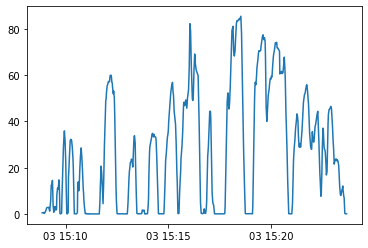

In [256]:
plt.plot(df["DateTime"], df["Speed"])

## Route Analysis (Distance)

#### Two ways of calculating distance
First with geopy
Second with explicitly calculated Haversine function

In [415]:
#Calculating distance traveled between each successive lat long pair using geopy

df['Coordinates'] = list(zip(df.Latitude, df.Longitude))
Distance = np.zeros(len(df))
Slope = np.zeros(len(df))
Slope_tan = np.zeros(len(df))
l_route = df.shape[0]

for i in range(1,l_route):
    elev_change = df.Altitude.iloc[i]-df.Altitude.iloc[i-1]
    dist_lateral = geopy.distance.geodesic(df.Coordinates.iloc[i_ref],  # Lateral distance in meters - dist between two lat/lon coord pairs
                                       df.Coordinates.iloc[i]).m
    dist_3d = np.sqrt(dist_lateral**2 + elev_change**2)  # 3d dist -- accounting for elevation
    Distance[i] = dist_3d/1e3 
    #print(dist_lateral, dist_3d)
    if Distance[i] > 0:
        Slope[i] = np.arccos(dist_lateral/dist_3d) # Would rather use arcsin since that uses 1 measured value instead of 2 calculated values, but that doesn't work
        
df['Distance_3D_km'] = list(Distance)
df['slope_rad'] = list(Slope) 

In [257]:
# Calculating distance between two lat long points with Haversine formula
def haversine(lat1, lon1, lat2, lon2, earth_radius=6371):
    """
    slightly modified version: of http://stackoverflow.com/a/29546836/2901002
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees or in radians)
    All (lat, lon) coordinates must have numeric dtypes and be of equal length.

    """
    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2
    
    return earth_radius * 2 * np.arcsin(np.sqrt(a)) 

# Not accounting for elevataion change
df['dist_no_elev'] = \
        haversine(df.Latitude.shift(), df.Longitude.shift(),
                 df.loc[1:, 'Latitude'], df.loc[1:, 'Longitude']) # in m

# Accounting for elevation change
df['dist_elev_change'] = \
    np.sqrt(haversine(df.Latitude.shift(), df.Longitude.shift(),
                 df.loc[1:, 'Latitude'], df.loc[1:, 'Longitude'])**2 + df['ElevChange']**2) #in m



In [317]:
# Sanity checking the distance on the route in KM 
print(df.dist_elev_change.sum())
print(df.Distance_3D_km.sum())

6.864298793288392

## Energy Requirements Analysis 
To-Do: implement vehicle parameters, get estimated energy consumption for a route. Get SoC along route

In [416]:
# Functions to retrieve the four different types of forces acting on the vehicle
# obtained from https://x-engineer.org/ev-design-energy-consumption/\

def getInertialForce(mass, accel):
    return mass * accel

def getRoadSlopeForce(mass, slope, grav = 9.81):
    return mass * grav * np.sin(slope)

def getRoadFriction(mass, c_rr, slope, grav = 9.81): #c_rr is coeff of rolling resistance
    return mass * grav * c_rr * np.cos(slope)

def getAerodynamicDrag(c_d, A, vel, rho = 1.204,): # rho is air density 20C, c_d is air drag coeff
    return 0.5 * rho * c_d * A * vel**2



In [457]:
class Vehicle:
    """
    Inputs: Physical parameters of vehicle for modeling energy consumption
    """
    def __init__(self, imei = (None), mass = 3500, 
                 cd = 0.36, crr = 0.02, height = 1.995, width = 1.880,
                 eff = 0.9, rgbeff = 0.75, cap = 100, p0 = 1000):
        self.imei = imei # data logger identifier
        self.reg_n = 'n/a' # registration number
        self.frames = {} # where routes data will be stored
        self.journey_info = [] # journey_dT objects linekd here
        self.v2g_stops = None 
        
        # Vehicle physical parameters
        self.mass = mass # kg
        self.load = 0.0 #kg
        self.crr = crr # coefficient of rolling resistance
        self.cd = cd  # air drag coefficient
        self.A = height * width * 0.85 # m^2, Approximation of vehicle frontal area 
        self.eff = eff
        self.rgeff = rgbeff # regen brake efficiency
        self.capacity = cap # kWh
        self.battery = cap
        self.p0 = p0 # constant power loss in W (to run the vehicle besides driving)
        
    def getEnergyExpenditure(self,cycle,regbrake = True):
        # computes energy expenditure from a Drivecycle object
        # dt default 1 second
        
        v = cycle.velocity # m/s
        s = cycle.slope # rad
        a = cycle.acceleration # m/s^2
        dt = cycle.dt # s
        
        if regbrake == True:
            RGBeff = rgbeff
        else:
            RGBeff = 0
                        
        Fr = [] # Drag force (Constance's model). Inertial force + Road load(friction) + Aerodynamic drag
        Er = [] # energy dissipated from drag
        for slope,vel,acc,delta_time in zip(s,v,a,dt):
            force = getInertialForce(self.mass, acc) + getRoadFriction(self.mass,self.crr, slope) + getAerodynamicDrag(self.cd, self.A, vel**2)
            Fr.append(force)
            Er.append(force*vel*delta_time)
        
            
        Fs = [] # slope component (defined as drag) - slope is broken out from rest of total road load, in case EV brakes on downhill 
        Es = [] # energy associated to slope
        for slope,vel,delta_time in zip(s,v,dt):
            force = getRoadSlopeForce(self.mass, slope)
            Fs.append(force)
            Es.append(force*vel*delta_time)
            
        # drivetrain energy (wheel side): engine/brake force counteracts drag forces
        Em = [x+y for x,y in zip(Es,Er)] # from battery if positive, to battery if negative (RGbrake)
        # takes into account efficiency of charge/discharge etc...
        Em_eff = [0.0]*len(Em) 
        for i in range(len(Em)):
            if Em[i] > 0:
                Em_eff[i] = Em[i]/self.eff
            elif Em[i] < 0:
                Em_eff[i]= Em[i]*RGBeff 
         
        # adds constant loss p0 (1 kW)
        for i in range(len(Em_eff)):
            if v[i] > 2: # [m/s] to make sure that the vehicle is not parked (and engine maybe turned off)
                Em_eff[i] += self.p0

        return Em_eff

In [453]:
class Drivecycle: 
    """
    Inputs: dataframe with journey info
    """
    def __init__(self, journey_df): 
        self.displacement = journey_df.Distance_3D_km # m
        self.velocity = journey_df.Speed/3.6 # convert km/h to m/s
        self.acceleration = journey_df.Acceleration # m/s^2
        self.slope = journey_df.slope_rad
        self.time = journey_df.RelTime.max() # Total Time Elapsed
        self.dt = journey_df.TimeDif

In [454]:
# Create drivecycle object from journey data, and instantiate create vehicle object
journey = df
drvcycle = Drivecycle(journey)
minibus = Vehicle()

In [455]:
# Compute energy expenditure (with and without regenerative braking)

enJ = minibus.getEnergyExpenditure(drvcycle)
enJnoRG = minibus.getEnergyExpenditure(drvcycle, regbrake = False) 

journey['PowerW'] = enJnoRG
journey['PowerW_RG'] = enJ
journey['SoC_RG'] = np.array(enJ)/3.6e6/minibus.capacity # decrease in SoC


In [456]:
print("Total energy consumption for the route:\n", journey.PowerW.sum()/1e3, "kWh")
if journey.PowerW_RG.sum()/1e3 > 50:
    print("That's too high bro!!!")
else:
    print("Let's get some EVs up in here")

Total energy consumption for the route:
 421960.26626805234 kWh
That's too high bro!!!


## Figure out what the SOC_RG calculation is doing and adjust for my purposes

In [ ]:
# Plotting route on Folium
map1 = folium.Map(
    location=[df["Latitude"][1], df["Longitude"][1]],
    tiles='cartodbpositron',
    zoom_start=12,
)
df.apply(lambda row:folium.CircleMarker(location=[row["Latitude"], row["Longitude"]]).add_to(map1), axis=1)
map1

## Extra processing if needed, to use in the EV Fleet Simulator

In [244]:
newdf.to_csv("ev-fleet-sim-master/src/test_johan/_Inputs/Traces/Processed/test_johan.csv")

In [ ]:
newdf["Time"] = newdf["DateTime"]
newdf = newdf.drop(labels = ["DateTime"], axis = 1)

In [242]:
newdf["GPSID"] = newdf.index
newdf

,Latitude,Longitude,Altitude,Heading,X-Axis Acceleration,Y-Axis Acceleration,Z-Axis Acceleration,Velocity,Time,GPSID
0,-33.93113,18.85856,119.0,329.52,0.020,0.188,1.028,0.46,2022-03-10 15:08:51,0
1,-33.93113,18.85856,119.2,329.52,0.054,0.156,1.062,0.52,2022-03-10 15:08:53,1
2,-33.93113,18.85856,119.5,329.52,0.052,0.174,1.026,0.61,2022-03-10 15:08:55,2
3,-33.93113,18.85855,119.6,329.52,0.008,0.160,0.964,0.35,2022-03-10 15:08:56,3
4,-33.93113,18.85855,119.7,329.52,0.052,0.072,1.056,0.30,2022-03-10 15:08:57,4
...,...,...,...,...,...,...,...,...,...,...
613,-33.96375,18.84001,128.2,59.04,-0.076,0.160,0.952,7.07,2022-03-10 15:23:34,613
614,-33.96373,18.84003,128.1,35.08,0.028,0.142,1.024,0.26,2022-03-10 15:23:36,614
615,-33.96373,18.84003,127.9,35.08,0.104,0.116,0.960,0.09,2022-03-10 15:23:37,615
616,-33.96373,18.84003,128.8,35.08,0.112,0.156,0.994,0.07,2022-03-10 15:23:39,616
